In [19]:
from random import randint

from datasets import load_dataset
ds = load_dataset("cnn_dailymail", "3.0.0", split="train[:10000]")
df = ds.to_pandas()

In [20]:
from nltk.tokenize import sent_tokenize
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from utils import preprocessing

In [21]:
def extract_and_clean_sentences(text):
    # 1. Découpage en phrases (avec ponctuation)
    sentences = sent_tokenize(text)

    # 2. Nettoyage phrase par phrase (retrait ponctuation, lemmatisation, etc.)
    cleaned_sentences = [preprocessing(sentence) for sentence in sentences]

    return cleaned_sentences

# Exemple d’utilisation sur une colonne 'article' d’un DataFrame pandas df
df['article_sentences'] = df['article'].apply(extract_and_clean_sentences)
df['summary_sentences'] = df['highlights'].apply(extract_and_clean_sentences)

df

,article,highlights,id,article_sentences,summary_sentences
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4,[london england reuters harry potter star dani...,[harry potter star daniel radcliffe get fortun...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9,[editor note behind scenes series cnn correspo...,[mentally ill inmate miami house forgotten flo...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37,[minneapolis minnesota cnn driver minneapolis ...,"[new thought go die driver say, man say pickup..."
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88,[washington cnn doctor remove five small polyp...,[five small polyp find procedure none worrisom...
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a,[cnn national football league indefinitely sus...,[new nfl chief atlanta falcon owner critical m...
...,...,...,...,...,...
9995,"(Oprah.com) -- As a trained chef, restaurant o...",Chef Laura Pensiero: Don't let diet hijack you...,75cd2144a44f902e14b887bf927a08ad6b5fbf54,[trained chef restaurant owner author confirm ...,"[chef laura pensiero let diet hijack life, eas..."
9996,"Islamabad, Pakistan (CNN) -- The Pakistani mil...",NEW: Taliban source says commander alive and w...,734ca9a754dd444ed50362375e256fd72d82def5,[islamabad pakistan cnn pakistani military sun...,[new taliban source say commander alive well r...
9997,(CNN) -- Bastian Schweinsteiger rescued a poin...,Midfielder Bastian Schweinsteiger rescues a po...,8ff4e932c84ed30759427a128879f0af1c8a156a,[cnn bastian schweinsteiger rescue point bayer...,[midfielder bastian schweinsteiger rescue poin...
9998,"(CNN) -- Haiti's earthquake is creating ""a gen...","Experts say Haiti's earthquake is creating ""a ...",12e6c95b6f47092e953523ae556cb6391a7021f6,[cnn haiti earthquake create generation ampute...,[expert say haiti earthquake create generation...


# Labelisation des données

On cherche a affecté un label a une phrase si elle est présente dans le résume de l'article.
On utilise cosine_similarity pour detecter les phrase qui ne serait pas les meme mais proches.


In [22]:
# Detecte la similirité entre deux phrase, threshold correspond au seuil de similarité renvoyé par cosine_similarity
def label_phrases_by_similarity(articles, summarys, threshold=0.5):
    all_sents = list(articles) + list(summarys)
    # On fit le vectorizer
    vectorizer = TfidfVectorizer().fit(all_sents)
    # On transforme en vecteur
    article_vecs = vectorizer.transform(articles)
    summary_vecs = vectorizer.transform(summarys)
    # On calcule la similarité entre les phrases
    sim_matrix = cosine_similarity(article_vecs, summary_vecs)
    max_sim = sim_matrix.max(axis=1)

    labels = (max_sim >= threshold).astype(int)
    return labels

In [23]:
data = []
for idx, row in df.iterrows():
    articles = row["article_sentences"]
    summarys = row["summary_sentences"]
    labels = label_phrases_by_similarity(articles, summarys, threshold=0.4)

    for sent, label in zip(articles, labels):
        data.append({"id": idx, "sentence": sent, "label": label})

clean_df = pd.DataFrame(data)

print(f"Nombre total de phrases : {len(clean_df)}")
print(f"Nombre de phrases résumées (label=1) : {clean_df['label'].sum()}")
clean_df

Nombre total de phrases : 329883
Nombre de phrases résumées (label=1) : 21468


,id,sentence,label
0,0,london england reuters harry potter star danie...,1
1,0,daniel radcliffe harry potter harry potter ord...,1
2,0,plan one people soon turn suddenly buy massive...,0
3,0,think particularly extravagant,0
4,0,thing like buy thing cost pound book cd dvd,0
...,...,...,...
329878,9999,captain say solidity seaworthiness navigation ...,0
329879,9999,frederic castaignos,0
329880,9999,web site,0
329881,9999,,0


# Choix et entrainement du model

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [25]:
from sklearn.model_selection import train_test_split

X = clean_df["sentence"]
y = clean_df["label"]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [26]:
# from sklearn.model_selection import GroupShuffleSplit
#
# # On cherche a garder les articles complet avec leur id
#
# X = df['sentence']
# y = df['label']
# groups = df['id']
#
# gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
# train_idx, test_idx = next(gss.split(X, y, groups=groups))
#
# X_train = X.iloc[train_idx]
# X_test = X.iloc[test_idx]
# y_train = y.iloc[train_idx]
# y_test = y.iloc[test_idx]

In [27]:
import optuna
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

def objective(trial):
    model_name = trial.suggest_categorical("model", ["LinearSVC", "RandomForest", "XGBoost"])
    max_features = trial.suggest_int("max_features", 1000, 10000, step=1000)

    # Classifieur
    if model_name == "LinearSVC":
        clf = LinearSVC(C=trial.suggest_float("C", 1e-3, 10, log=True), max_iter=5000)
    elif model_name == "RandomForest":
        clf = RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators_rf", 50, 300, step=50),
            max_depth=trial.suggest_int("max_depth_rf", 5, 30),
            min_samples_split=trial.suggest_int("min_samples_split_rf", 2, 10),
            random_state=42,
            n_jobs=-1
        )
    else:
        clf = XGBClassifier(
            n_estimators=trial.suggest_int("n_estimators_xgb", 50, 300, step=50),
            max_depth=trial.suggest_int("max_depth_xgb", 3, 15),
            learning_rate=trial.suggest_float("learning_rate_xgb", 0.01, 0.3, log=True),
            subsample=trial.suggest_float("subsample_xgb", 0.5, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree_xgb", 0.5, 1.0),
            eval_metric="logloss",
            n_jobs=-1,
            random_state=42
        )

    pipeline = ImbPipeline([
        ('vectorizer', TfidfVectorizer(max_features=max_features)),
        ('smote', SMOTE(random_state=42)),
        ('classifier', clf)
    ])

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    f1 = f1_score(y_test, preds, average='macro')
    acc = accuracy_score(y_test, preds)

    return f1, acc

study = optuna.create_study(
    directions=["maximize", "maximize"]  # Maximiser F1 macro et Accuracy
)
study.optimize(objective, n_trials=50)

print("Best trials:")
for t in study.best_trials:
    print(f"F1 macro: {t.values[0]:.4f}, Accuracy: {t.values[1]:.4f}, Params: {t.params}")

[I 2025-06-22 17:07:08,223] A new study created in memory with name: no-name-a9b033d7-77bc-421b-b30c-bbffdfc8b8b5
[I 2025-06-22 17:07:44,023] Trial 0 finished with values: [0.5321629953474284, 0.9073128736161802] and parameters: {'model': 'XGBoost', 'max_features': 1000, 'n_estimators_xgb': 150, 'max_depth_xgb': 12, 'learning_rate_xgb': 0.08767091673229228, 'subsample_xgb': 0.8271935896021108, 'colsample_bytree_xgb': 0.7853517095844678}.
[I 2025-06-22 17:07:49,646] Trial 1 finished with values: [0.441440116272828, 0.5925598089025234] and parameters: {'model': 'RandomForest', 'max_features': 4000, 'n_estimators_rf': 50, 'max_depth_rf': 7, 'min_samples_split_rf': 4}.
[I 2025-06-22 17:07:56,848] Trial 2 finished with values: [0.509697743524084, 0.7539013713911557] and parameters: {'model': 'LinearSVC', 'max_features': 9000, 'C': 0.27774260274757556}.
[I 2025-06-22 17:08:18,774] Trial 3 finished with values: [0.520621962853432, 0.9097985958700634] and parameters: {'model': 'XGBoost', 'max_

Best trials:
F1 macro: 0.5322, Accuracy: 0.9073, Params: {'model': 'XGBoost', 'max_features': 1000, 'n_estimators_xgb': 150, 'max_depth_xgb': 12, 'learning_rate_xgb': 0.08767091673229228, 'subsample_xgb': 0.8271935896021108, 'colsample_bytree_xgb': 0.7853517095844678}
F1 macro: 0.5158, Accuracy: 0.9182, Params: {'model': 'XGBoost', 'max_features': 6000, 'n_estimators_xgb': 50, 'max_depth_xgb': 8, 'learning_rate_xgb': 0.012486176021133525, 'subsample_xgb': 0.7426215787355972, 'colsample_bytree_xgb': 0.8866320354693}
F1 macro: 0.5229, Accuracy: 0.9124, Params: {'model': 'XGBoost', 'max_features': 8000, 'n_estimators_xgb': 100, 'max_depth_xgb': 8, 'learning_rate_xgb': 0.026972376911351254, 'subsample_xgb': 0.94278673218481, 'colsample_bytree_xgb': 0.5497912723614989}
F1 macro: 0.5359, Accuracy: 0.9022, Params: {'model': 'XGBoost', 'max_features': 10000, 'n_estimators_xgb': 100, 'max_depth_xgb': 15, 'learning_rate_xgb': 0.10469639691302446, 'subsample_xgb': 0.5895488789640084, 'colsample_b

In [38]:
from sklearn.metrics import classification_report

def build_best_pipeline(best_params):
    # 1. Vectorizer
    vectorizer = TfidfVectorizer(max_features=best_params["max_features"])

    # 2. SMOTE
    smote = SMOTE(random_state=42)

    # 3. Modèle
    if best_params["model"] == "LinearSVC":
        clf = LinearSVC(C=best_params["C"], max_iter=5000)
    elif best_params["model"] == "RandomForest":
        clf = RandomForestClassifier(
            n_estimators=best_params["n_estimators_rf"],
            max_depth=best_params["max_depth_rf"],
            min_samples_split=best_params["min_samples_split_rf"],
            random_state=42
        )
    else:  # XGBoost
        clf = XGBClassifier(
            n_estimators=best_params["n_estimators_xgb"],
            max_depth=best_params["max_depth_xgb"],
            learning_rate=best_params["learning_rate_xgb"],
            subsample=best_params["subsample_xgb"],
            colsample_bytree=best_params["colsample_bytree_xgb"],
            eval_metric="logloss",
            random_state=42
        )

    # 4. Pipeline complète
    pipeline = ImbPipeline([
        ('vectorizer', vectorizer),
        ('smote', smote),
        ('classifier', clf)
    ])

    return pipeline

# Construire la pipeline avec les meilleurs paramètres
best_trial = max(study.best_trials, key=lambda t: t.values[0])
best_params = best_trial.params
pipeline = build_best_pipeline(best_params)

# Entraînement complet dans la pipeline (SMOTE inclus)
pipeline.fit(X_train, y_train)

# Prédiction
y_preds = pipeline.predict(X_test)

# Rapport détaillé
print(classification_report(y_test, y_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9422    0.9496    0.9459     77104
           1     0.1842    0.1636    0.1733      5367

    accuracy                         0.8984     82471
   macro avg     0.5632    0.5566    0.5596     82471
weighted avg     0.8929    0.8984    0.8956     82471



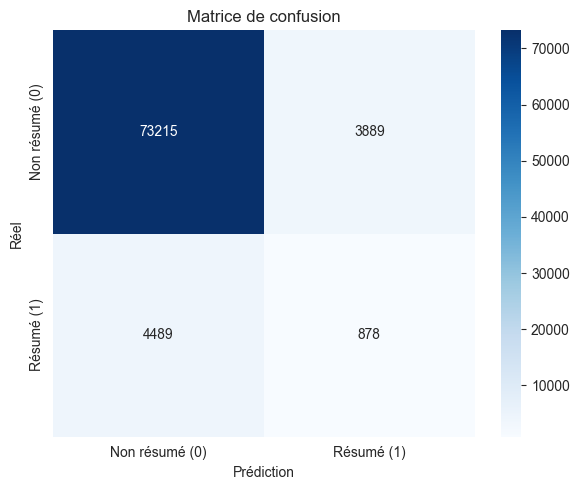

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculer la matrice
cm = confusion_matrix(y_test, y_preds)

# Afficher avec seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Non résumé (0)", "Résumé (1)"],
            yticklabels=["Non résumé (0)", "Résumé (1)"])
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.tight_layout()
plt.show()

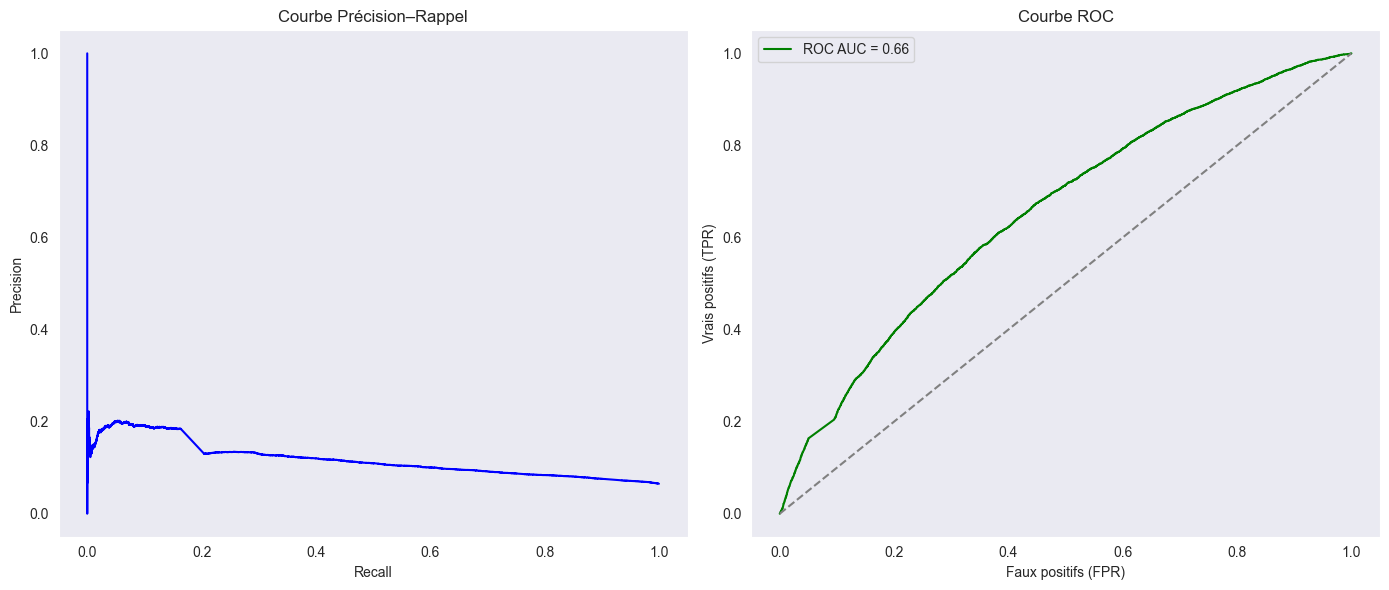

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Étape 1 : obtenir les probabilités (ou scores) du modèle
# Si ton modèle supporte predict_proba (LogReg, XGBoost...) :
y_scores = pipeline.predict_proba(X_test)[:, 1]

# Étape 2 : récupérer les vraies étiquettes
# y_test doit déjà être défini, sinon remplace-le ici

# Étape 3 : calculer les courbes
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Étape 4 : affichage
plt.figure(figsize=(14, 6))

# Courbe Précision–Rappel
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label="Courbe PR", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Précision–Rappel")
plt.grid()

# Courbe ROC
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}", color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Faux positifs (FPR)")
plt.ylabel("Vrais positifs (TPR)")
plt.title("Courbe ROC")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [48]:
# Exemple d'article sous forme de phrases
article = """“Global Climate Summit Sparks Hope and Debate”

The recent Global Climate Summit brought together leaders from over 190 countries to discuss urgent actions to combat climate change. The summit focused on reducing carbon emissions, investing in renewable energy, and supporting vulnerable nations impacted by rising sea levels. While many countries pledged to strengthen their climate commitments, some delegates expressed concerns over the feasibility of these targets and the economic impact of rapid transitions.

Environmental activists praised the summit’s emphasis on sustainable development but urged for faster implementation and greater accountability. Discussions also highlighted the role of technology and innovation in addressing climate challenges, including advancements in carbon capture and storage. The summit concluded with a call for continued collaboration and increased funding to meet global climate goals."""

# 1. Tokenize en phrases
sentences = sent_tokenize(article)

# 2. Nettoyage phrase par phrase
cleaned_sentences = [preprocessing(sentence) for sentence in sentences]

# 3. Vectorisation via pipeline (seulement vectorizer, pas SMOTE)
# pipeline est ton ImbPipeline entraîné
vectorizer = pipeline.named_steps['vectorizer']
X_article_vec = vectorizer.transform(cleaned_sentences)

# 4. Prédiction avec ton classifieur
clf = pipeline.named_steps['classifier']

# Prédictions (avec ton modèle entraîné sur train oversamplé)
predictions = clf.predict(X_article_vec)
probas = None
if hasattr(clf, "predict_proba"):
    probas = clf.predict_proba(X_article_vec)

# Afficher les phrases importantes prédites
print("Phrases sélectionnées pour le résumé :")
for sent, pred in zip(sentences, predictions):
    if pred == 1:  # Classe "phrase résumée"
        print(f"- {sent}")

# Optionnel : afficher la confiance si disponible
if probas is not None:
    for sent, prob in zip(sentences, probas):
        print(f"{sent} => classe 1 prob : {prob[1]:.3f}")

Phrases sélectionnées pour le résumé :
- “Global Climate Summit Sparks Hope and Debate”

The recent Global Climate Summit brought together leaders from over 190 countries to discuss urgent actions to combat climate change.
“Global Climate Summit Sparks Hope and Debate”

The recent Global Climate Summit brought together leaders from over 190 countries to discuss urgent actions to combat climate change. => classe 1 prob : 0.564
The summit focused on reducing carbon emissions, investing in renewable energy, and supporting vulnerable nations impacted by rising sea levels. => classe 1 prob : 0.370
While many countries pledged to strengthen their climate commitments, some delegates expressed concerns over the feasibility of these targets and the economic impact of rapid transitions. => classe 1 prob : 0.254
Environmental activists praised the summit’s emphasis on sustainable development but urged for faster implementation and greater accountability. => classe 1 prob : 0.169
Discussions also 

In [49]:
from scipy.special import softmax

article = """“Global Climate Summit Sparks Hope and Debate”

The recent Global Climate Summit brought together leaders from over 190 countries to discuss urgent actions to combat climate change. The summit focused on reducing carbon emissions, investing in renewable energy, and supporting vulnerable nations impacted by rising sea levels. While many countries pledged to strengthen their climate commitments, some delegates expressed concerns over the feasibility of these targets and the economic impact of rapid transitions.

Environmental activists praised the summit’s emphasis on sustainable development but urged for faster implementation and greater accountability. Discussions also highlighted the role of technology and innovation in addressing climate challenges, including advancements in carbon capture and storage. The summit concluded with a call for continued collaboration and increased funding to meet global climate goals."""

# 1. Tokenize en phrases
sentences = sent_tokenize(article)

# 2. Nettoyage phrase par phrase
cleaned_sentences = [preprocessing(sentence) for sentence in sentences]

# 3. Vectorisation via pipeline (seulement vectorizer, pas SMOTE)
# pipeline est ton ImbPipeline entraîné
vectorizer = pipeline.named_steps['vectorizer']
X_article_vec = vectorizer.transform(cleaned_sentences)

# 4. Prédiction avec ton classifieur
clf = pipeline.named_steps['classifier']

if hasattr(clf, "predict_proba"):
    probas = clf.predict_proba(X_article_vec)[:, 1]
elif hasattr(clf, "decision_function"):
    decision_scores = clf.decision_function(X_article_vec)
    # Softmax sur scores (pour approximer proba)
    probas = softmax(np.vstack([-decision_scores, decision_scores]), axis=0)[1]
else:
    raise ValueError("Le modèle ne supporte ni predict_proba ni decision_function")

# 5. Récupérer les indices des 3 phrases les plus probables
top_k = 3
top_k_idx = np.argsort(probas)[-top_k:][::-1]

# 6. Affichage résumé
print("Résumé extrait (top 3 phrases) :\n")
for idx in sorted(top_k_idx):
    print(f"- {sentences[idx]} (proba: {probas[idx]:.4f})")

Résumé extrait (top 3 phrases) :

- “Global Climate Summit Sparks Hope and Debate”

The recent Global Climate Summit brought together leaders from over 190 countries to discuss urgent actions to combat climate change. (proba: 0.5636)
- The summit focused on reducing carbon emissions, investing in renewable energy, and supporting vulnerable nations impacted by rising sea levels. (proba: 0.3700)
- The summit concluded with a call for continued collaboration and increased funding to meet global climate goals. (proba: 0.3156)


In [50]:
article = """““Breakthrough in Quantum Computing Promises Unprecedented Processing Power”

A team of researchers from MIT and Google has announced a major milestone in quantum computing, unveiling a new quantum processor capable of solving complex problems at speeds far beyond traditional supercomputers.
The processor, named “QuantaX,” leverages a novel qubit stabilization technique that significantly reduces error rates, which has been one of the most persistent challenges in quantum systems.
According to the team, this advancement could eventually revolutionize fields like cryptography, pharmaceutical development, and climate modeling by enabling previously infeasible simulations.
However, experts caution that while the breakthrough is remarkable, commercial applications are still years away due to engineering limitations and high operational costs.
The announcement has reignited global interest and competition in quantum technologies, with major tech firms and governments accelerating their investments in research.
Analysts note that the race for quantum supremacy is as much geopolitical as it is technological, with nations seeking to secure strategic advantages through computing power."""

# 1. Tokenize en phrases
sentences = sent_tokenize(article)

# 2. Nettoyage phrase par phrase
cleaned_sentences = [preprocessing(sentence) for sentence in sentences]

# 3. Vectorisation
X_article_vec = vectorizer.transform(cleaned_sentences)

# 4. Calcul des probabilités de la classe 1 (phrase à inclure dans résumé)
if hasattr(clf, "predict_proba"):
    probas = clf.predict_proba(X_article_vec)[:, 1]
elif hasattr(clf, "decision_function"):
    decision_scores = clf.decision_function(X_article_vec)
    # Approximation softmax pour transformer score en probabilité
    probas = softmax(np.vstack([-decision_scores, decision_scores]), axis=0)[1]
else:
    raise ValueError("Le modèle ne supporte ni predict_proba ni decision_function")

# 5. Récupérer les indices des 3 phrases avec les plus grandes probabilités
top_k = 3
top_k_idx = np.argsort(probas)[-top_k:][::-1]

# 6. Affichage résumé et détails
print("Résumé extrait (top 3 phrases) :\n")
for idx in sorted(top_k_idx):
    print(f"- {sentences[idx]} (proba: {probas[idx]:.4f})")

Résumé extrait (top 3 phrases) :

- ““Breakthrough in Quantum Computing Promises Unprecedented Processing Power”

A team of researchers from MIT and Google has announced a major milestone in quantum computing, unveiling a new quantum processor capable of solving complex problems at speeds far beyond traditional supercomputers. (proba: 0.5498)
- The processor, named “QuantaX,” leverages a novel qubit stabilization technique that significantly reduces error rates, which has been one of the most persistent challenges in quantum systems. (proba: 0.3067)
- However, experts caution that while the breakthrough is remarkable, commercial applications are still years away due to engineering limitations and high operational costs. (proba: 0.3014)


In [51]:
# import joblib
# import random
#
# model_name = best_trial.params['model']
# rand = random.randint(0,9)
# # Enregistrer la pipeline
# joblib.dump(pipeline, f'ML_Sumarizer/summarize_pipeline_{model_name}_{rand}.pkl')

['ML_Sumarizer/summarize_pipeline_XGBoost.pkl']